<a href="https://colab.research.google.com/github/Collin0034/MW_pulsar_detection/blob/main/Multiple_circles_in_Grayscale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cv2
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Convolution2D, MaxPooling2D, Flatten

%matplotlib inline

In [ ]:
# Activate GPU for this, otherwise the convnet will take forever to train
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print(
        '\n\nThis error most likely means that this notebook is not '
        'configured to use a GPU.  Change this in Notebook Settings via the '
        'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
    raise SystemError('GPU device not found')




This error most likely means that this notebook is not configured to use a GPU.  Change this in Notebook Settings via the command palette (cmd/ctrl-shift-P) or the Edit menu.




SystemError: ignored

In [ ]:
'''
Few things to keep in mind in order to increase IOU:

Increase num_imgs
Increase epochs
Decrease img_size
Decrease the number of available shapes to chose from
Decrease the number of colors that are available
'''


num_imgs = 5

img_size = 32
min_object_size = 4
max_object_size = 16
num_objects = 2

boxes = np.zeros((num_imgs, num_objects, 4)) #use this to later to put a square around objects so we can keep track of object boundaries
imgs = np.zeros((num_imgs, img_size, img_size, 3))  # format: BGR

colors = np.zeros((num_imgs, num_objects), dtype=int) #use this to keep track of color information
num_colors = 3
color_labels = np.linspace(.2,1,num_colors)

shapes = np.zeros((num_imgs, num_objects), dtype=int)
num_shapes = 2
shape_labels = ['rectangle', 'circle', 'triangle']

# radii = np.zeros((num_imgs, num_objects)) #use this to keep track of radius information for each circle
# radii_labels = []
# num_radii = rmax
# for i in range(rmin, rmax+1):
#     radii_labels.append('r = %d' %(i))

for i_img in range(num_imgs):
    # Draw circle
    for i_object in range(num_objects):
        shape = np.random.randint(num_shapes)
        # shape = 2
        shapes[i_img, i_object] = shape
        if shape == 0:  # rectangle
            w, h = np.random.randint(min_object_size, max_object_size, size=2) # represents the bottom right corner of rectangle 
            x = np.random.randint(0, img_size - w) #x coordinate for the top left corner of rectangle (for the box this will be the bottom left)
            y = np.random.randint(0, img_size - h) #y coordinate for the top left corner of rectangle (for the box this will be the bottom left)
            boxes[i_img, i_object] = [x, y, w+1, h+1] #add 1 since cv2 implements their pixel values starting from the bottom left corner of the pixel square, 
                                                      #so... the values added to the numpy array, imgs, will have a w and h value that are 1 pixel larger in the x and y coordinates
                                                      #ex) if x,y = 1,1 and w,h = 2,3 then cv2.rectangle will have fill coordinates from (1,1)-the bottom left of the rectangle- up to (4,5)-the top right of the rectangle- since cv2 implemented its pixel at (3,3)            
            color = int(np.random.randint(num_colors)) #provides a random index value for the color of the object and square boxes to be chosen from
            colors[i_img, i_object] = color #keeps track of the color for this object in this image
            #format for cv2.rectangle(image, start_point, end_point, color, thickness)  #start pt is top left and end pt is bottom right of rectangle
            cv2.rectangle(imgs[i_img], (x,y), (x+w,y+h), color_labels[color]*np.array([1,1,1]), -1) #we subtract one at the end point since this is cv2 format and we are using a matplotlib format to display the image 
        elif shape == 1:  # circle   
            r = int(0.5 * np.random.randint(min_object_size, max_object_size))
            x = int(np.random.randint(r,img_size-r)) #x spawn location (img_size -r is there to prevent circle from going outside the image)
            y = int(np.random.randint(r,img_size-r)) #y spawn location (img_size -r is there to prevent circle from going outside the image)
            boxes[i_img, i_object] = [x - r, y - r, 2 * r+1, 2 * r+1] #add 1 since cv2 implements their pixel values starting from the bottom left corner of the pixel square, 
                                                                      #so... the values added to the numpy array, imgs, will have a w and h value that are 1 pixel larger in the x and y coordinates
                                                                      #ex) if x,y = 1,1 and w,h = 2,3 then cv2.rectangle will have fill coordinates from (1,1)-the bottom left of the rectangle- up to (4,5)-the top right of the rectangle- since cv2 implemented its pixel at (3,3)            

            color = int(np.random.randint(num_colors)) #provides a random index value for the color of the object and square boxes to be chosen from
            colors[i_img, i_object] = color #keeps track of the color for this object in this image
            cv2.circle(imgs[i_img], (x,y), r, color_labels[color]*np.array([1,1,1]), -1) #plots circle on the image
        elif shape == 2:  # triangle
            w, h = np.random.randint(min_object_size, max_object_size, size=2) #distance values from starting point
            x = np.random.randint(0, img_size - w) #x coordinate for the top left corner of triangle 
            y = np.random.randint(0, img_size - h) #y coordinate for the "top left" corner of triangle
            boxes[i_img, i_object] = [x, y, w+1, h+1] #add 1 since cv2 implements their pixel values starting from the bottom left corner of the pixel square, 
                                                      #so... the values added to the numpy array, imgs, will have a w and h value that are 1 pixel larger in the x and y coordinates
                                                      #ex) if x,y = 1,1 and w,h = 2,3 then cv2.rectangle will have fill coordinates from (1,1)-the bottom left of the rectangle- up to (4,5)-the top right of the rectangle- since cv2 implemented its pixel at (3,3)            
            pt1 = np.array([x, y]) #bottom left corner
            pt2 = np.array([x+w, y]) #bottom right corner
            pt3 = np.array([x, y+w]) #top left corner
            pts = np.array([pt1, pt2, pt3])
            pts = pts.reshape((-1, 1, 2))
            color = int(np.random.randint(num_colors)) #provides a random index value for the color of the object and square boxes to be chosen from
            colors[i_img, i_object] = color #keeps track of the color for this object in this image
            cv2.fillPoly(imgs[i_img], [pts], color_labels[color]*np.array([1,1,1])) #cv2.fillPolly(image, corner_pts, color)




imgs.shape, boxes.shape, shapes.shape, colors.shape

((5, 32, 32, 3), (5, 2, 4), (5, 2), (5, 2))

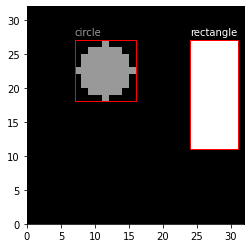

In [ ]:
i = np.random.randint(num_imgs) #randomly selected image index number
plt.imshow(imgs[i], interpolation='none', origin='lower', extent=[0, img_size, 0, img_size]) #plots image with boxes
for box, shape, color in zip(boxes[i], shapes[i], colors[i]):
    plt.gca().add_patch(matplotlib.patches.Rectangle((box[0], box[1] ), box[2], box[3], ec='r', fc='none')) #gives rectangular box around circle
    plt.annotate(shape_labels[shape], (box[0], box[1] + box[3] + 0.7), color=color_labels[color]*np.array([1,1,1]), clip_on=False) #gives radius of circle above the square box in the same color as the circle it is refering to

In [ ]:
#Reshape and normalize the image data to mean 0 and std 1. 
#Differs from the original github format here because they used cairo and were plotting in rgb instead of grayscale

X = (imgs - np.mean(imgs)) /np.std(imgs)
print(X.shape, np.mean(X), np.std(X))
print(np.mean(imgs), np.std(imgs))

(5, 32, 32, 3) 1.850371707708594e-17 0.9999999999999999
0.104296875 0.2588079149972705


In [ ]:

# Normalize x, y, w, h, shape, and colors by img_size, so that all values are between 0 and 1.

colors_onehot = np.zeros((num_imgs, num_objects, num_colors))
for i_img in range(num_imgs):
    for i_object in range(num_objects):
        colors_onehot[i_img, i_object, colors[i_img, i_object]] = 1 #normalizes the color label values 

shapes_onehot = np.zeros((num_imgs, num_objects, num_shapes))
for i_img in range(num_imgs):
    for i_object in range(num_objects):
        shapes_onehot[i_img, i_object, int(shapes[i_img, i_object])] = 1 #normalizes shapes label values

# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = np.concatenate([boxes / img_size, shapes_onehot, colors_onehot], axis=-1).reshape(num_imgs, -1) #normalize y and then store color and shapes values with the information at the end of the array
y.shape, np.all(np.argmax(colors_onehot, axis=-1) == colors) #NOTE about where 261 comes from: Boxes is a 3x4 matrix, colors_onehot is a 3x81, and shapes_onehot is a 3x2 matrix so when these are concetenated (i.e. (4+81+32)*3) it becomes 261

((5, 18), True)

In [ ]:
# print(boxes.shape, colors_onehot.shape)
# print(boxes)
# print(colors_onehot)
# # print(np.concatenate([boxes, colors_onehot], axis = -1))#.reshape(num_imgs,-1)
# np.concatenate([boxes, colors_onehot], axis = -1).reshape(num_imgs,-1)
# # print(colors_onehot.shape)
# # print(colors_onehot)
# # print(boxes/img_size)
print(y.shape[-1])

18


In [ ]:
i = int(0.8 * num_imgs) #take 80% of images to input into the training model and then feed the other 20% of the images to test the neural network
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]

test_imgs = imgs[i:]
test_boxes = boxes[i:]

In [ ]:
# TODO: Make one run with very deep network (~10 layers).
filter_size = 3
pool_size = 2

# TODO: Maybe remove pooling bc it takes away the spatial information.

model = Sequential([
        Convolution2D(32, (6, 6), input_shape=X.shape[1:], data_format="channels_last", activation='relu'), #give weights and bias to algorithm
                                                                                                  #dim_ordering: 'th' or 'tf'. In 'th' mode, the channels dimension (the depth) is at index 1, in 'tf' mode is it at index 3. 
        MaxPooling2D(pool_size=(pool_size, pool_size)), #use Max Pooling to reduce the spatial dimensions (height and width) of the output volume by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input
        Convolution2D(64, (filter_size, filter_size), data_format="channels_last", activation='relu'), 
        MaxPooling2D(pool_size=(pool_size, pool_size)), 
        Convolution2D(128, (filter_size, filter_size), data_format="channels_last", activation='relu'), 
# #         MaxPooling2D(pool_size=(pool_size, pool_size)), 
        Convolution2D(128, (filter_size, filter_size), data_format="channels_last", activation='relu'), 
# #         MaxPooling2D(pool_size=(pool_size, pool_size)), 
        Flatten(), 
        Dropout(0.4), #The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.
        Dense(256, input_dim=X.shape[-1], activation='relu'), #256 represents the number of functions the model uses where in each funciton there are a set of parameters that are used so when pixels are fed inside of each of them, one by one, the combination of all these function will determine the correct value
#                                                             #relu takes input tensor and has the probability curve that trends in a linear direction towards any input value greater than zero (https://alexisalulema.com/2017/10/15/activation-functions-in-tensorflow/)
        Dropout(0.4), 
        Dense(y.shape[-1]) #output shape
    ])

model.compile('adadelta', 'mse') #optimizer, adelta, is a standard stochastic gradient descent, but with an adaptive learning rate
                                 # 'mse', Mean Squared Error, is the loss function for the network 


In [ ]:
print(train_y)

[[0.75    0.65625 0.25    0.21875 1.      0.      1.      0.      0.
  0.28125 0.4375  0.40625 0.40625 0.      1.      0.      1.      0.     ]
 [0.4375  0.25    0.34375 0.34375 0.      1.      0.      0.      1.
  0.53125 0.21875 0.28125 0.4375  1.      0.      0.      1.      0.     ]
 [0.21875 0.5625  0.28125 0.28125 0.      1.      0.      1.      0.
  0.75    0.34375 0.21875 0.5     1.      0.      0.      0.      1.     ]
 [0.25    0.5     0.46875 0.46875 0.      1.      1.      0.      0.
  0.46875 0.125   0.25    0.46875 1.      0.      0.      0.      1.     ]]


In [ ]:
# Flip boxes during training.
# Note: The validation loss is always quite big here because we don't flip the bounding boxes for the validation data. 
def IOU(box1, box2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = box1[0], box1[1], box1[2], box1[3]  
    x2, y2, w2, h2 = box2[0], box2[1], box2[2], box2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0
    I = w_I * h_I #intersection

    U = w1 * h1 + w2 * h2 - I #union

    return I / U

def dist(box1, box2):
    return np.sqrt(np.sum(np.square(box1[:2] - box2[:2])))

num_epochs_flipping = 1
num_epochs_no_flipping = 0  # has no significant effect

flipped_train_y = np.array(train_y)
flipped = np.zeros((len(train_y), num_epochs_flipping + num_epochs_no_flipping))
ious_epoch = np.zeros((len(train_y), num_epochs_flipping + num_epochs_no_flipping))
dists_epoch = np.zeros((len(train_y), num_epochs_flipping + num_epochs_no_flipping))
mses_epoch = np.zeros((len(train_y), num_epochs_flipping + num_epochs_no_flipping))
acc_shapes_epoch = np.zeros((len(train_y), num_epochs_flipping + num_epochs_no_flipping))
acc_colors_epoch = np.zeros((len(train_y), num_epochs_flipping + num_epochs_no_flipping))
# print(acc_shapes_epoch.shape)
# print(acc_colors_epoch.shape)


flipped_test_y = np.array(test_y)
flipped_test = np.zeros((len(test_y), num_epochs_flipping + num_epochs_no_flipping))
ious_test_epoch = np.zeros((len(test_y), num_epochs_flipping + num_epochs_no_flipping))
dists_test_epoch = np.zeros((len(test_y), num_epochs_flipping + num_epochs_no_flipping))
mses_test_epoch = np.zeros((len(test_y), num_epochs_flipping + num_epochs_no_flipping))
acc_shapes_test_epoch = np.zeros((len(test_y), num_epochs_flipping + num_epochs_no_flipping))
acc_colors_test_epoch = np.zeros((len(test_y), num_epochs_flipping + num_epochs_no_flipping))

# Use GPU for this, otherwise the convnet will take forever to train




# TODO: Calculate ious directly for all samples (using slices of the array pred_y for x, y, w, h).
for epoch in range(num_epochs_flipping):
    print ('Epoch', epoch) #indicate the current epoch that we're on in the for loop
    model.fit(train_X, flipped_train_y, epochs=1, validation_data=(test_X, test_y), verbose=2) #training the model with 80% of images
    pred_y = model.predict(train_X) #training the model with 80% of images
    print(pred_y)

    for sample, (pred, exp) in enumerate(zip(pred_y, flipped_train_y)): 
        print('sample', sample)
        # print(pred)
        pred = pred.reshape(num_objects, -1) #predicted values for training
        print(pred)
        exp = exp.reshape(num_objects, -1) #expected values fot training
        
        pred_boxes = pred[:, :4] #4 is for the four corners of the box
        exp_boxes = exp[:, :4]
        
        ious = np.zeros((num_objects, num_objects)) #training IOU array
        dists = np.zeros((num_objects, num_objects)) #training distance apart array
        mses = np.zeros((num_objects, num_objects)) #Training Mean Squared Error array
        for i, exp_box in enumerate(exp_boxes):
            for j, pred_box in enumerate(pred_boxes):
                ious[i, j] = IOU(exp_box, pred_box) #appends IOU calulation for each object in each image
                dists[i, j] = dist(exp_box, pred_box) #appends distance calulation for each object in each image
                mses[i, j] = np.mean(np.square(exp_box - pred_box)) #appends mean squared error calulation for each object in each image
                
        new_order = np.zeros(num_objects, dtype=int)
        
        for i in range(num_objects):
            # Find pred and exp box with maximum iou and assign them to each other (i.e. switch the positions of the exp boxes in y).
            ind_exp_box, ind_pred_box = np.unravel_index(ious.argmax(), ious.shape) #detect the index for the max IOU between the pred and exp box
            ious_epoch[sample, epoch] += ious[ind_exp_box, ind_pred_box] #assign the IOU values for both boxes to eachother for the appropriate epoch
            dists_epoch[sample, epoch] += dists[ind_exp_box, ind_pred_box]#assign the distance values for both boxes to eachother for the appropriate epoch
            mses_epoch[sample, epoch] += mses[ind_exp_box, ind_pred_box] #assign the mean squared error values for both boxes to eachother for the appropriate epoch
            ious[ind_exp_box] = -1  # set iou of assigned boxes to -1, so they don't get assigned again
            ious[:, ind_pred_box] = -1
            new_order[ind_pred_box] = ind_exp_box #assign index values of the max iou expected box to track if we need to flip the image based on MSE values that we'll compare later on
        
        flipped_train_y[sample] = exp[new_order].flatten() #match these indeces with the y sample
        
        flipped[sample, epoch] = 1. - np.mean(new_order == np.arange(num_objects, dtype=int)) #check to see if images meet criteria to be flipped (mse_A > mse_B)
        ious_epoch[sample, epoch] /= num_objects #finds the mean iou for a given epoch
        dists_epoch[sample, epoch] /= num_objects #finds the mean distance for a given epoch
        mses_epoch[sample, epoch] /= num_objects #finds the mean mean square value for a given epoch
        
        acc_shapes_epoch[sample, epoch] = np.mean(np.argmax(pred[:, 4:4+num_shapes], axis=-1) == np.argmax(exp[:, 4:4+num_shapes], axis=-1)) #finds the accuracy that the neural network has at predicting shapes of the objects
        acc_colors_epoch[sample, epoch] = np.mean(np.argmax(pred[:, 4+num_shapes:4+num_shapes+num_colors], axis=-1) == np.argmax(exp[:, 4+num_shapes:4+num_shapes+num_colors], axis=-1))

    
    # Calculate metrics on test data. 
    pred_test_y = model.predict(test_X)
    for sample, (pred, exp) in enumerate(zip(pred_test_y, flipped_test_y)):
        
        # TODO: Make this simpler.
        pred = pred.reshape(num_objects, -1) 
        exp = exp.reshape(num_objects, -1) 
        
        pred_boxes = pred[:, :4]
        exp_boxes = exp[:, :4]
        
        ious = np.zeros((num_objects, num_objects)) #IOU array
        dists = np.zeros((num_objects, num_objects)) #distance apart array
        mses = np.zeros((num_objects, num_objects)) #Mean Squared Error array
        for i, exp_box in enumerate(exp_boxes):
            for j, pred_box in enumerate(pred_boxes):
                ious[i, j] = IOU(exp_box, pred_box)
                dists[i, j] = dist(exp_box, pred_box)
                mses[i, j] = np.mean(np.square(exp_box - pred_box))
                
        new_order = np.zeros(num_objects, dtype=int)
        
        for i in range(num_objects):
            # Find pred and exp box with maximum iou and assign them to each other (i.e. switch the positions of the exp boxes in y).
            ind_exp_box, ind_pred_box = np.unravel_index(mses.argmin(), mses.shape)
            ious_test_epoch[sample, epoch] += ious[ind_exp_box, ind_pred_box]
            dists_test_epoch[sample, epoch] += dists[ind_exp_box, ind_pred_box]
            mses_test_epoch[sample, epoch] += mses[ind_exp_box, ind_pred_box]
            mses[ind_exp_box] = 1000000#-1  # set iou of assigned boxes to -1, so they don't get assigned again
            mses[:, ind_pred_box] = 10000000#-1
            new_order[ind_pred_box] = ind_exp_box
        
        flipped_test_y[sample] = exp[new_order].flatten()
        
        flipped_test[sample, epoch] = 1. - np.mean(new_order == np.arange(num_objects, dtype=int))#np.array_equal(new_order, np.arange(num_objects, dtype=int))  # TODO: Change this to reflect the number of flips.
        ious_test_epoch[sample, epoch] /= num_objects
        dists_test_epoch[sample, epoch] /= num_objects
        mses_test_epoch[sample, epoch] /= num_objects
        
        acc_shapes_test_epoch[sample, epoch] = np.mean(np.argmax(pred[:, 4:4+num_shapes], axis=-1) == np.argmax(exp[:, 4:4+num_shapes], axis=-1))
        acc_colors_test_epoch[sample, epoch] = np.mean(np.argmax(pred[:, 4+num_shapes:4+num_shapes+num_colors], axis=-1) == np.argmax(exp[:, 4+num_shapes:4+num_shapes+num_colors], axis=-1))
       
            
    print ('Flipped {} % of all elements'.format(np.mean(flipped[:, epoch]) * 100.))
    print ('Mean IOU: {}'.format(np.mean(ious_epoch[:, epoch])))
    print ('Mean dist: {}'.format(np.mean(dists_epoch[:, epoch])))
    print ('Mean mse: {}'.format(np.mean(mses_epoch[:, epoch])))
    print ('Accuracy shapes: {}'.format(np.mean(acc_shapes_epoch[:, epoch])))
    print ('Accuracy colors: {}'.format(np.mean(acc_colors_epoch[:, epoch])))
    
    print ('--------------- TEST ----------------')
    print ('Flipped {} % of all elements'.format(np.mean(flipped_test[:, epoch]) * 100.))
    print ('Mean IOU: {}'.format(np.mean(ious_test_epoch[:, epoch])))
    print ('Mean dist: {}'.format(np.mean(dists_test_epoch[:, epoch])))
    print ('Mean mse: {}'.format(np.mean(mses_test_epoch[:, epoch])))
    print ('Accuracy shapes: {}'.format(np.mean(acc_shapes_test_epoch[:, epoch])))
    print ('Accuracy colors: {}'.format(np.mean(acc_colors_test_epoch[:, epoch])))
    print()
    
# print '------------------------------------'
# print 'Training now without flipping boxes'
# print '------------------------------------'

# print(num_epochs_flipping, num_epochs_flipping + num_epochs_no_flipping)
# for epoch in range(num_epochs_flipping):#, num_epochs_flipping + num_epochs_no_flipping):
    
#     print 'Epoch', epoch
#     model.fit(train_X, flipped_train_y, nb_epoch=1, validation_data=(test_X, test_y), verbose=2)
#     pred_y = model.predict(train_X)

#     # Calculate iou/dist, but don't flip.
#     for sample, (pred_boxes, exp_boxes) in enumerate(zip(pred_y, flipped_train_y)):
        
#         pred_boxes = pred_boxes.reshape(num_objects, -1)
#         exp_boxes = exp_boxes.reshape(num_objects, -1)        
#         for exp_box, pred_box in zip(exp_boxes, pred_boxes):
#             ious_epoch[sample, epoch] += IOU(exp_box, pred_box)
#             dists_epoch[sample, epoch] += dist(exp_box, pred_box)
#             mses_epoch[sample, epoch] += np.mean(np.square(exp_box - pred_box))
            
#         ious_epoch[sample, epoch] /= num_objects
#         dists_epoch[sample, epoch] /= num_objects 
#         mses_epoch[sample, epoch] /= num_objects 
            
# #     print 'Flipped {} % of all elements'.format(np.mean(flipped[:, epoch]) * 100.)
#     print 'Mean IOU: {}'.format(np.mean(ious_epoch[:, epoch]))
#     print 'Mean dist: {}'.format(np.mean(dists_epoch[:, epoch]))
#     print 'Mean mse: {}'.format(np.mean(mses_epoch[:, epoch]))
#     print
    

Epoch 0
1/1 - 0s - loss: 0.3185 - val_loss: 0.3319
[[-6.36307523e-02 -1.29489735e-01  8.04383904e-02 -4.40443261e-03
   3.21062689e-04  2.88671076e-01  1.88942645e-02  7.23875314e-02
   1.21309899e-01  1.60716385e-01  3.75780016e-02 -7.25969896e-02
   1.39325991e-01 -6.88615441e-02 -9.26462114e-02 -8.33887309e-02
   1.22939358e-02  4.09798287e-02]
 [-1.84804261e-01 -3.09926927e-01  7.46814013e-02  4.94650155e-02
   1.88196301e-02  2.38773003e-01 -9.46306903e-03  1.72704428e-01
   1.10383995e-01  3.19309831e-01  9.63361636e-02 -3.67749743e-02
   3.29353124e-01 -5.02985567e-02 -2.42559589e-03 -1.29818931e-01
  -9.86266211e-02  1.05872564e-01]
 [-5.12438752e-02 -8.53957534e-02 -6.08528741e-02  5.81030175e-02
  -3.36670838e-02  1.39213502e-01  8.66258591e-02  7.41350651e-02
   6.78449348e-02  7.54778534e-02  4.58170883e-02 -1.43668145e-01
   7.81950206e-02 -4.43395190e-02 -1.14845112e-01 -6.99024349e-02
   6.30325964e-03  1.71265565e-02]
 [-2.75444090e-01 -4.09096897e-01  1.23183236e-01  6

In [ ]:
# # model.layers
# weights = model.layers[0].get_weights()[0]
# # print(weights)
# # print(weights.shape)
# weights = weights.transpose(3, 0, 1, 2)
# print weights.shape
# # plt.imshow(weights[0] * 255. + 128., interpolation='none', origin='lower')
# print np.mean(weights[0]), np.std(weights[0]), np.min(weights[0]), np.max(weights[0])
# adj_weights = (weights * 255.) + 128.
# print np.mean(adj_weights[0]), np.std(adj_weights[0]), np.min(adj_weights[0]), np.max(adj_weights[0])
# plt.figure(figsize=(16, 8))
# for i in range(24):
#     plt.subplot(4, 6, i+1)
#     plt.imshow(adj_weights[i, :, :], interpolation='none', origin='lower', cmap='Greys')


Text(0, 0.5, 'Training sample')

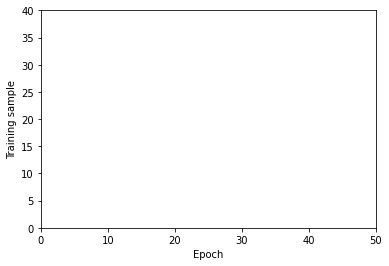

In [ ]:
plt.pcolor(flipped[:1000], cmap='Greys', vmax=1.)
# plt.axvline(num_epochs_flipping, c='r')
plt.xlabel('Epoch')
plt.ylabel('Training sample')

(0.0, 0.4)

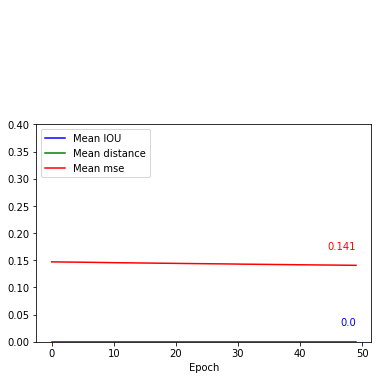

In [ ]:
mean_ious_epoch = np.mean(ious_epoch, axis=0)
mean_dists_epoch = np.mean(dists_epoch, axis=0)
mean_mses_epoch = np.mean(mses_epoch, axis=0)
plt.plot(mean_ious_epoch, color='b', label='Mean IOU')  # between predicted and assigned true boxes
plt.plot(mean_dists_epoch, color ='g', label='Mean distance')  # relative to image size
plt.plot(mean_mses_epoch, color = 'r', label='Mean mse')  # relative to image size
plt.annotate(np.round(np.max(mean_ious_epoch), 3), (len(mean_ious_epoch)-1, mean_ious_epoch[-1]+0.03), horizontalalignment='right', color='b')
plt.annotate(np.round(np.min(mean_dists_epoch), 3), (len(mean_dists_epoch)-1, mean_dists_epoch[-1]+0.03), horizontalalignment='right', color='g')
plt.annotate(np.round(np.min(mean_mses_epoch), 3), (len(mean_mses_epoch)-1, mean_mses_epoch[-1]+0.03), horizontalalignment='right', color='r')

# TEST.
# mean_ious_epoch = np.mean(ious_test_epoch, axis=0)
# mean_dists_epoch = np.mean(dists_test_epoch, axis=0)
# mean_mses_epoch = np.mean(mses_test_epoch, axis=0)
# plt.plot(mean_ious_epoch, 'b--')  # between predicted and assigned true boxes
# plt.plot(mean_dists_epoch, 'g--')  # relative to image size
# plt.plot(mean_mses_epoch, 'r--')  # relative to image size
# plt.annotate(np.round(np.max(mean_ious_epoch), 3), (len(mean_ious_epoch)-1, mean_ious_epoch[-1]+0.03), horizontalalignment='right', color='b')
# plt.annotate(np.round(np.min(mean_dists_epoch), 3), (len(mean_dists_epoch)-1, mean_dists_epoch[-1]+0.03), horizontalalignment='right', color='g')
# plt.annotate(np.round(np.min(mean_mses_epoch), 3), (len(mean_mses_epoch)-1, mean_mses_epoch[-1]+0.03), horizontalalignment='right', color='r')

# plt.axvline(num_epochs_flipping, c='r')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.ylim(0, 0.4)

# plt.savefig('plots/color-multiple-shapes_three-colors_boxes.png', dpi=300)

(0.6, 1.0)

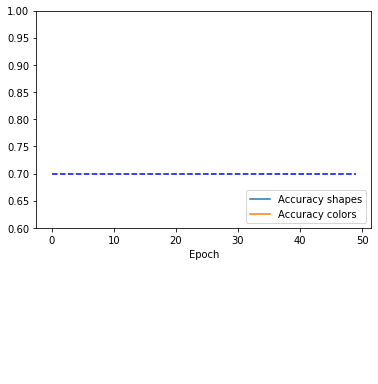

In [ ]:
mean_acc_shapes_epoch = np.mean(acc_shapes_epoch, axis=0)
mean_acc_colors_epoch = np.mean(acc_colors_epoch, axis=0)
plt.plot(mean_acc_shapes_epoch, label='Accuracy shapes')  # between predicted and assigned true boxes
plt.plot(mean_acc_colors_epoch, label='Accuracy colors')
plt.annotate(np.round(np.max(mean_acc_shapes_epoch), 3), (len(mean_acc_shapes_epoch)-1, mean_acc_shapes_epoch[-1]+0.03), horizontalalignment='right', color='b')
plt.annotate(np.round(np.max(mean_acc_colors_epoch), 3), (len(mean_acc_colors_epoch)-1, mean_acc_colors_epoch[-1]+0.03), horizontalalignment='right', color='g')

# TEST.
mean_acc_shapes_epoch = np.mean(acc_shapes_test_epoch, axis=0)
mean_acc_colors_epoch = np.mean(acc_colors_test_epoch, axis=0)
plt.plot(mean_acc_shapes_epoch, 'b--')  # between predicted and assigned true boxes
plt.plot(mean_acc_colors_epoch, 'g--')
# plt.annotate(np.round(np.max(mean_acc_shapes_epoch), 3), (len(mean_acc_shapes_epoch)-1, mean_acc_shapes_epoch[-1]+0.03), horizontalalignment='right', color='b')
# plt.annotate(np.round(np.max(mean_acc_colors_epoch), 3), (len(mean_acc_colors_epoch)-1, mean_acc_colors_epoch[-1]+0.03), horizontalalignment='right', color='g')

# plt.axvline(num_epochs_flipping, c='r')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.ylim(0.6, 1)

# plt.savefig('plots/color-multiple-shapes_three-colors_classification.png', dpi=300)

In [ ]:
print(y.shape)

(50, 18)


In [ ]:
pred_y = model.predict(test_X)
# print(pred_y)
pred_y = pred_y.reshape(len(pred_y), num_objects, -1)
print(pred_y)
pred_boxes = pred_y[..., :4] * img_size
# print(pred_boxes)
pred_shapes = np.argmax(pred_y[..., 4:4+num_shapes], axis=-1).astype(int)  # take max from probabilities
# print pred_y[..., 4+num_shapes:4+num_shapes+num_colors].shape
# print np.argmax(pred_y[..., 5:8], axis=-1).shape
pred_colors = np.argmax(pred_y[..., 4+num_shapes:4+num_shapes+num_colors], axis=-1).astype(int)
# print(pred_boxes)
pred_boxes.shape, pred_shapes.shape, pred_colors.shape

[[[-0.05734678  0.0275609   0.05719124 -0.04871532  0.20416635
    0.21063256 -0.11652391 -0.12179523  0.02987875]
  [-0.03732499 -0.04448166  0.1029304  -0.17557679 -0.07453119
    0.06952292  0.10110009  0.15999985  0.04937116]]

 [[-0.03503998  0.00280487 -0.0206176  -0.00910054  0.0465022
    0.05188828 -0.01837972 -0.0381476   0.03553566]
  [-0.04552377 -0.02567954  0.02348642 -0.03321886  0.00753963
    0.01242277  0.05335033  0.03787694  0.00994889]]

 [[-0.08771309  0.14958794 -0.05883307 -0.20244248  0.12158871
    0.26803416 -0.04683262 -0.079637    0.06577316]
  [-0.09551579 -0.24682078  0.07021804  0.04243976  0.04337204
    0.0655109   0.05332993 -0.03078658  0.03101327]]

 [[-0.0314126   0.03049242 -0.00492054 -0.02954068  0.04277818
    0.05035763 -0.04468855 -0.05867153  0.01726775]
  [-0.03517365 -0.03554977  0.02961728 -0.04340888 -0.00961749
    0.00567418  0.02776288  0.03996228  0.00335601]]

 [[-0.02487389  0.02217878 -0.02260186 -0.00137195  0.01027705
    0.0675

((10, 2, 4), (10, 2), (10, 2))

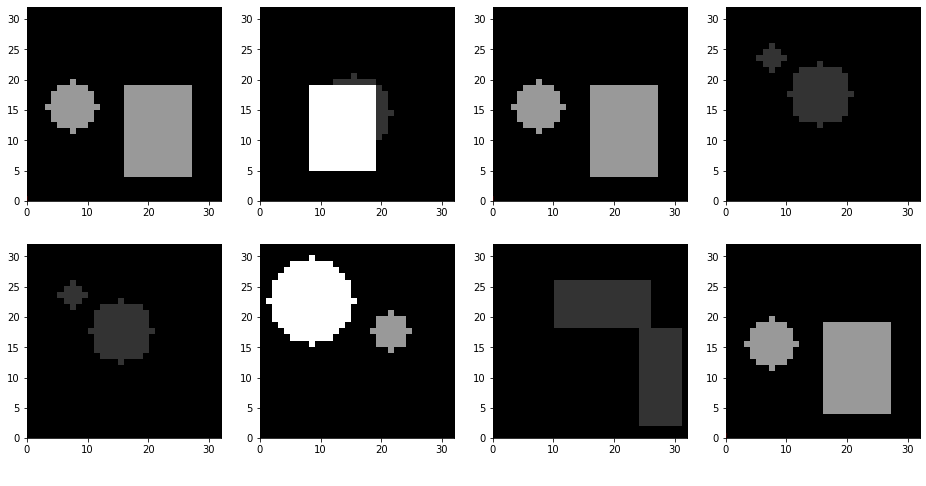

In [ ]:
plt.figure(figsize=(16, 8))
for i_subplot in range(1, 9):
    plt.subplot(2, 4, i_subplot)
    i = np.random.randint(len(test_X))
    plt.imshow(test_imgs[i], interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for box, shape, color in zip(pred_boxes[i], pred_shapes[i], pred_colors[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((box[0], box[1]), box[2], box[3], ec='r', fc='none'))
        plt.annotate(shape_labels[shape], (box[0], box[1] + box[3] + 0.7), color=color_labels[color]*np.array([1,1,1]), clip_on=False, bbox={'fc': 'w', 'ec': 'none', 'pad': 1, 'alpha': .7})

In [ ]:
np.mean(pred_boxes[:, :, 2]), np.std(pred_boxes[:, :, 2])

(-0.47812462, 0.11619733)